In [108]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time
import dateutil.parser

from matplotlib import gridspec
import scipy.optimize as sciop
import json
from scipy.stats import mode

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

from scipy.stats import binned_statistic

%matplotlib inline

In [129]:
# model target:
# Sp1003-0105 58752
# plotted in Delrez+2018 (1806.11205) figure 13 and Murray+2020 (2005.02423) figure 10, with water vapor correction
# note that Laetitia and Catriona's figures are both missing the second-to-last night in 2018 (May 5, or BJD 2458244) and 
#   Catriona's has an extra that isn't on the portal atm (2nd from left in her plot). Catriona's dates are also inconsistent with those given on the portal/in Laetitia's paper.


#empty arrays to hold all time, flux, fluxerr points
time = []
flux = []
fluxerr = []

# read in each light curve
lc_list = ! ls ./Sp1003-0105_3830128624846458752_all_nightly_data/*.json
#lc_list = ! ls ./Sp1048-3956_5393446658454453632_all_nightly_data/*.json


for lc_f in lc_list:
    lc = open(lc_f)
    data = json.load(lc)
    
    bjd = data['environment']['BJD-OBS']
    
    
    time = time + bjd
    flux = flux + data['stars'][data['best_ap']][0]['DIFF_FLUX']
    fluxerr = fluxerr + data['stars'][data['best_ap']][0]['ERROR']
    
    '''
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.errorbar(bjd, data['stars'][data['best_ap']][0]['DIFF_FLUX'], yerr = data['stars'][data['best_ap']][0]['ERROR'],color='k', markersize=10,capsize=0,linestyle='None',label="best ap = {0}".format(data['best_ap']))
    ax.set_xlim(bjd[0],bjd[-1])
    ax.set_ylim(0.98,1.02)
    plt.legend(loc="best")
    plt.show()
    '''
    lc.close()
    
time = np.array(time)
flux = np.array(flux)[np.argsort(time)]
fluxerr = np.array(fluxerr)[np.argsort(time)]
time = time[np.argsort(time)]

print(np.shape(time))
print(np.shape(flux))
print(np.shape(fluxerr))

(7275,)
(7275,)
(7275,)


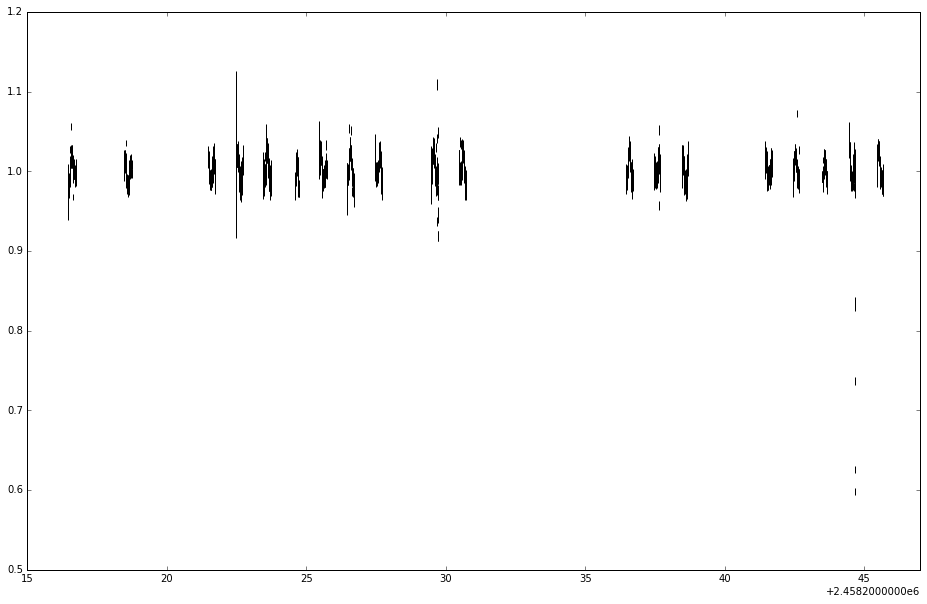

In [132]:
# plot all observations on the same plot

fig, ax = plt.subplots(1,1,figsize=(16,10))
ax.errorbar(time, flux, yerr=fluxerr, color='k', markersize=50, capsize=0, linestyle='None')
ax.set_xlim(2458215, 2458247)
plt.show()

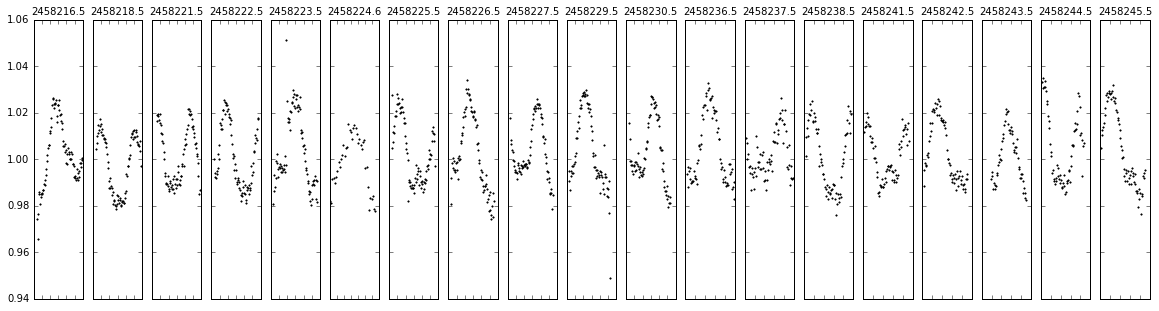

In [131]:
intervals = time[1:] - time[0:-1]
dayBeginningIdxs = np.arange(len(time)-1)[intervals > 0.25] + 1
dayBeginningIdxs = [0] + list(dayBeginningIdxs)

fig, axes = plt.subplots(1, 19, figsize=(20,5))
for i in range(19):

    #axes[i].errorbar(time[dayBeginningIdxs[i]:dayBeginningIdxs[i+1]], flux[dayBeginningIdxs[i]:dayBeginningIdxs[i+1]], yerr=fluxerr[dayBeginningIdxs[i]:dayBeginningIdxs[i+1]], color='c',ecolor='k',marker='.', markersize=1, capsize=0, linestyle='None')
    #axes[i].plot(time[dayBeginningIdxs[i]:dayBeginningIdxs[i+1]], flux[dayBeginningIdxs[i]:dayBeginningIdxs[i+1]], color='k',marker='.', markersize=3, linestyle='None')
    binned_flux,binned_time,binnumber = binned_statistic(x = time[dayBeginningIdxs[i]:dayBeginningIdxs[i+1]], 
                                   values=flux[dayBeginningIdxs[i]:dayBeginningIdxs[i+1]], 
                                   statistic="median", 
                                   bins = np.arange(time[dayBeginningIdxs[i]], time[dayBeginningIdxs[i+1]], 0.00347))
    
    axes[i].plot(binned_time[:-1],binned_flux,color='k',marker='.',markersize=3,linestyle='None')                                                                
    axes[i].set_ylim(0.94,1.06)
    if i > 0:
        axes[i].set_yticklabels([])
    axes[i].set_xticklabels([])
    axes[i].set_title(np.round(time[dayBeginningIdxs[i]], 1),fontsize=10)
plt.show()

In [133]:
print(mode(intervals))
print(np.min(intervals))

ModeResult(mode=array([0.0006622]), count=array([454]))
0.0005949996411800385


In [134]:
# LS periodogram of signal
frequency, power = LombScargle(time,flux).autopower(minimum_frequency=(1./(np.max(time)-np.min(time))), maximum_frequency=(1./(2.*0.000595)))

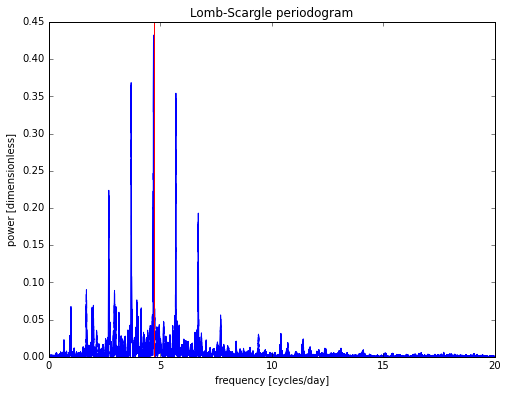

frequency of max power is 4.70238258448391 day^-1
corresponding period is 0.21265815403868307 day


In [135]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(frequency,power)
ax.set_xlabel('frequency [cycles/day]')
ax.set_ylabel('power [dimensionless]')
ax.set_title('Lomb-Scargle periodogram')
ax.set_xlim(0,20)
ax.axvline(frequency[np.argmax(power)],color='r')
plt.show()

print("frequency of max power is {0} day^-1".format(frequency[np.argmax(power)]))
print("corresponding period is {0} day".format(1./frequency[np.argmax(power)]))

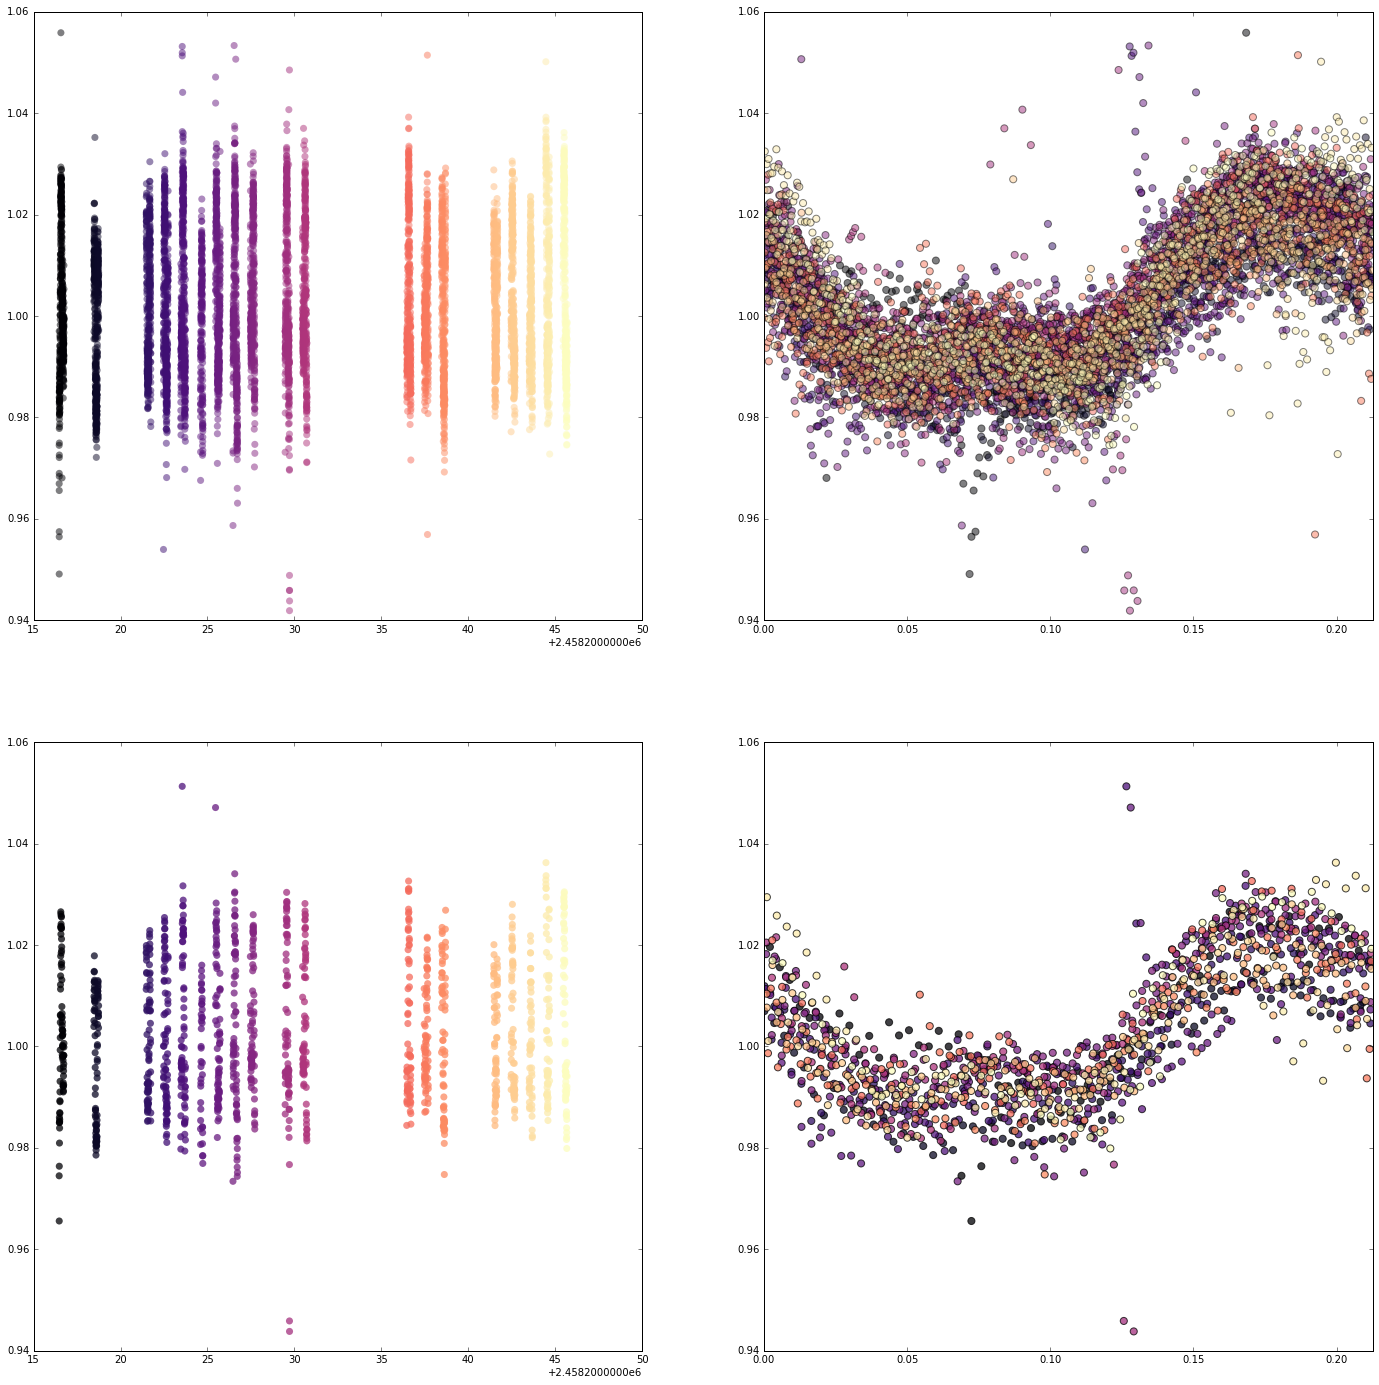

In [138]:
binned_flux,binned_time,binnumber = binned_statistic(x = time, 
                                   values=flux, 
                                   statistic="median", 
                                   bins = np.arange(time[0], time[-1], 0.00347))
    
binned_time = binned_time[0:-1]    




#phase fold the LC
test_per = 1./frequency[np.argmax(power)]

fig, axes = plt.subplots(2,2,figsize=(24,24))

axes[0,0].scatter(time[time < 2458250], flux[time < 2458250],c=time[time < 2458250],s=50,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.5)
axes[0,1].scatter(time[time < 2458250]%test_per, flux[time < 2458250],c=time[time < 2458250],s=50,cmap='magma',marker='o',edgecolor='k',linestyle='None',alpha=0.5)

#axes[0,0].scatter(time, flux,c=time,s=50,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.5)
#axes[0,1].scatter(time%test_per, flux,c=time,s=50,cmap='magma',marker='o',edgecolor='k',linestyle='None',alpha=0.75)


axes[1,0].scatter(binned_time[binned_time < 2458250], binned_flux[binned_time < 2458250],c=binned_time[binned_time < 2458250],s=50,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.75)
axes[1,1].scatter(binned_time[binned_time < 2458250]%test_per, binned_flux[binned_time < 2458250],c=binned_time[binned_time < 2458250],s=50,cmap='magma',marker='o',edgecolor='k',linestyle='None',alpha=0.75)

#axes[1,0].scatter(binned_time, binned_flux,c=binned_time,s=50,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.75)
#axes[1,1].scatter(binned_time%test_per, binned_flux,c=binned_time,s=50,cmap='magma',marker='o',edgecolor='k',linestyle='None',alpha=0.75)

for ax in np.ravel(axes):
    ax.set_ylim(0.94,1.06)
axes[0,1].set_xlim(0.,test_per)
axes[1,1].set_xlim(0.,test_per)
plt.show()